In [ ]:
!nvidia-smi -L

/bin/bash: nvidia-smi: command not found


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-25 10:50:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-25 10:50:58 (63.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data("nlp_getting_started.zip")

--2023-06-25 10:51:04--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-06-25 10:51:04 (114 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
import pandas as pd
train_df= pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
# Shuffle training data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Lets visualize some random sample
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Traget: {target}", "(real disater)" if target > 0 else "(not real disaster)")
  print(f"\nText:{text}\n")
  print("---\n")

Traget: 1 (real disater)

Text:US wont upgrade its infrastructure? http://t.co/NGEHhG9YGa' it a bad situation and its going to get ugly very quickly #USA #sustainability

---

Traget: 0 (not real disaster)

Text:#TBT to that time my best friend and I panicked at the disco. https://t.co/htpqvoHtUd

---

Traget: 0 (not real disaster)

Text:SCREAMING IN 22 DIFFERENT LANGUAGES http://t.co/rDfaAKKbNJ

---

Traget: 0 (not real disaster)

Text:*to Luka* They should all die! All of them! Everything annihilated! - Alois Trancy

---

Traget: 1 (real disater)

Text:Medieval airplane hijacker testa: earnings the distinction divers: HtaRvrGLY

---



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [ ]:
# Check len
len(train_sentences), len(val_sentences)

(6851, 762)

In [ ]:
# Check the fist 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
max_tokens=None,
standardize="lower_and_strip_punctuation",
split="whitespace",
ngrams=None,
output_mode="int",
output_sequence_length=None,
pad_to_max_tokens=False
)

In [ ]:
avg = round(sum(len(i.split()) for i in train_sentences) / len(train_sentences))

In [ ]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [ ]:
max_vocab_len = 10000
max_lenght = avg
text_vectorizer = TextVectorization(max_tokens=max_vocab_len,
                                    output_mode="int",
                                    output_sequence_length=max_lenght)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's flood in my street! "
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from training dataset
random_sentence = random.choice(train_sentences)
print(f"Original text: \n {random_sentence} \n \n Vectorized version: \n {text_vectorizer([random_sentence])} ")

Original text: 
 FAAN orders evacuation of abandoned aircraft at MMA http://t.co/GsOMtDPmoJ 
 
 Vectorized version: 
 [[1679 1268  245    6 1441  661   17 2041    1    0    0    0    0    0
     0]] 


In [ ]:
# Get the unique in vocabulary
words_in_vocabulary = text_vectorizer.get_vocabulary() # get all of the list and index them
top_5_words = words_in_vocabulary[:5] # get the most common
bottom_5_words = words_in_vocabulary[-5:]
print(f"Number in vocab {len(words_in_vocabulary)} \n- 5most common words: {top_5_words} \n- Least common words: {bottom_5_words}")

Number in vocab 10000 
- 5most common words: ['', '[UNK]', 'the', 'a', 'in'] 
- Least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_len,
                             output_dim=128,
                             input_length=max_lenght)
embedding

In [ ]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\nEmbedded version:")
# Turn it into (dense into dense vector)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed # 1 - token 15 - vectorized and 128 - embedding output_shape

Original text:
 @FaZe_Rain all hail the Cloud

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00379617, -0.04859922,  0.04141213, ...,  0.03764323,
          0.04496939, -0.02171121],
        [-0.02376738,  0.00809962, -0.04511123, ..., -0.01417146,
         -0.02810557, -0.03869637],
        [-0.01180168,  0.04803867, -0.02680613, ..., -0.01241456,
          0.01615523, -0.00658087],
        ...,
        [ 0.03159276, -0.02173415,  0.00026209, ...,  0.00566355,
          0.02989105,  0.0229633 ],
        [ 0.03159276, -0.02173415,  0.00026209, ...,  0.00566355,
          0.02989105,  0.0229633 ],
        [ 0.03159276, -0.02173415,  0.00026209, ...,  0.00566355,
          0.02989105,  0.0229633 ]]], dtype=float32)>

In [ ]:
# Check out a single token embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00379617, -0.04859922,  0.04141213,  0.00411562, -0.01474671,
         0.03590575, -0.04982268, -0.04883632, -0.03735539, -0.04312508,
        -0.01634169, -0.01174336,  0.04759011, -0.02999469, -0.04444723,
         0.02012041, -0.02667945,  0.02376083,  0.04738792, -0.01341452,
        -0.00030955,  0.03983298,  0.04490963, -0.03655066, -0.00300205,
        -0.02486814,  0.0436201 ,  0.02769746,  0.01857109,  0.04511248,
        -0.01068004, -0.02370602,  0.01423177, -0.00032919, -0.04021496,
         0.00995622,  0.02229771, -0.01797441,  0.04391764,  0.00449045,
         0.01673341, -0.00194738,  0.01284136,  0.02738928,  0.03571292,
         0.02215364,  0.01558429,  0.00020709, -0.01899655,  0.02876823,
         0.04730804, -0.02937218, -0.0122825 , -0.02498407, -0.02394762,
         0.01464817,  0.04867018, -0.00395981,  0.00384549,  0.00364264,
        -0.04241684,  0.02259165, -0.03646768, -0.01374316,  0.03286698,
  

In [ ]:
# Model 0 --Naive Bayes:
# non-DL great use as baseline

from sklearn.feature_extraction.text import TfidfVectorizer # Turn text to num TF-IDF formula
from sklearn.naive_bayes import MultinomialNB # Naive Base (alghorythm of Naive base)
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Conver the words
    ("clf", MultinomialNB())
])
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our model achives an accuracy of: {baseline_score*100:.2f}%")

Our model achives an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
# Create an evaluation fucntion for our model experiments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1score using "weighted" (label imbalance)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support (y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1-score": model_f1}

  return model_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1-score': 0.7862189758049549}

In [ ]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback
# Log dir
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
# Difference between `GlobalMaxPool1D()(X)`
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230625-105108
Epoch 1/5
215/215 [==============================] - 14s 58ms/step - loss: 0.6127 - accuracy: 0.6869 - val_loss: 0.5355 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 11s 51ms/step - loss: 0.4407 - accuracy: 0.8194 - val_loss: 0.4760 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 11s 51ms/step - loss: 0.3467 - accuracy: 0.8596 - val_loss: 0.4661 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 11s 50ms/step - loss: 0.2841 - accuracy: 0.8914 - val_loss: 0.4677 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 12s 54ms/step - loss: 0.2379 - accuracy: 0.9101 - val_loss: 0.4792 - val_accuracy: 0.7835


In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4792 - accuracy: 0.7835


[0.4791567027568817, 0.7834645509719849]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 1s 6ms/step


(762, 1)

In [ ]:
model_1.summary() # Get ridd of the token

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
model_1_pred_probs[:10]

array([[0.3716286 ],
       [0.80710155],
       [0.99751765],
       [0.152849  ],
       [0.10877956],
       [0.9381658 ],
       [0.9115202 ],
       [0.9933927 ],
       [0.97210646],
       [0.32709673]], dtype=float32)

In [ ]:
# Convert model prediction probs to label format
model_1_preds_conv = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds_conv[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds_conv)
model_1_results

{'accuracy': 78.34645669291339,
 'precision': 0.7868445599717488,
 'recall': 0.7834645669291339,
 'f1-score': 0.7809185675137833}

In [ ]:
import numpy as np
np.array(list(model_1_results.values()) > np.array(list(baseline_results.values())))

array([False, False, False, False])

In [ ]:
# Get teh vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Get the weight matirx of embedding layer
# Numberical representations of each toke in our training data
embed_weights = model_1.get_layer("embedding_2").get_weights()[0]
embed_weights.shape

ValueError: ignored

In [ ]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

NameError: ignored

In [ ]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
max_length = 15
model_2_embedding = layers.Embedding(input_dim=max_vocab_len,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# Must be return_sequences=True to be stacked (Needs to be 3dim to stacking)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230625-105240
Epoch 1/5
215/215 [==============================] - 19s 77ms/step - loss: 0.5111 - accuracy: 0.7437 - val_loss: 0.4552 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 10s 48ms/step - loss: 0.3179 - accuracy: 0.8729 - val_loss: 0.5076 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 12s 56ms/step - loss: 0.2203 - accuracy: 0.9164 - val_loss: 0.5868 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 12s 57ms/step - loss: 0.1549 - accuracy: 0.9451 - val_loss: 0.6334 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 12s 56ms/step - loss: 0.1076 - accuracy: 0.9602 - val_loss: 0.9046 - val_accuracy: 0.7598


In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 2s 13ms/step


array([[0.01257022],
       [0.77187604],
       [0.99922436],
       [0.04872971],
       [0.00376331],
       [0.99937385],
       [0.9693668 ],
       [0.9996872 ],
       [0.99944174],
       [0.558908  ]], dtype=float32)

In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0

In [ ]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.98425196850394,
 'precision': 0.760643337272643,
 'recall': 0.7598425196850394,
 'f1-score': 0.7579915356353872}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1-score': 0.7862189758049549}

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#x = layers.LSTM(64, return_sequences=True)(x)
#x = layers.GRU(64, return_sequences=True)(x)
#x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.summary() # note: we dont get tokens, but sequence on the output (we need)

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230625-105408
Epoch 1/5
215/215 [==============================] - 15s 55ms/step - loss: 0.2309 - accuracy: 0.9089 - val_loss: 0.5339 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 11s 53ms/step - loss: 0.1597 - accuracy: 0.9431 - val_loss: 0.5997 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 11s 52ms/step - loss: 0.1281 - accuracy: 0.9521 - val_loss: 0.7572 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 11s 49ms/step - loss: 0.1093 - accuracy: 0.9603 - val_loss: 0.7646 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 11s 53ms/step - loss: 0.0917 - accuracy: 0.9672 - val_loss: 0.7396 - val_accuracy: 0.7874


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[4.7407072e-02],
       [8.2695633e-01],
       [9.9934614e-01],
       [5.7199884e-02],
       [8.2799594e-04],
       [9.8970711e-01],
       [5.9500772e-01],
       [9.9965560e-01],
       [9.9934620e-01],
       [6.2447166e-01]], dtype=float32)

In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 78.74015748031496,
 'precision': 0.7903907506573856,
 'recall': 0.7874015748031497,
 'f1-score': 0.7850997256765829}

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
print(x.shape) # From L to R, R to L (Double it)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

(None, 15, 128)


In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [ ]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230625-105536
Epoch 1/5
215/215 [==============================] - 33s 110ms/step - loss: 0.1217 - accuracy: 0.9623 - val_loss: 0.8568 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 24s 110ms/step - loss: 0.0823 - accuracy: 0.9699 - val_loss: 0.8227 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 16s 77ms/step - loss: 0.0686 - accuracy: 0.9731 - val_loss: 1.1322 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 16s 75ms/step - loss: 0.0645 - accuracy: 0.9752 - val_loss: 1.0736 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 17s 81ms/step - loss: 0.0550 - accuracy: 0.9768 - val_loss: 1.4152 - val_accuracy: 0.7769


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs

24/24 [==============================] - 3s 23ms/step


array([[8.34289458e-05],
       [6.59237385e-01],
       [9.99875188e-01],
       [8.97059068e-02],
       [4.78729498e-06],
       [9.99818444e-01],
       [8.59349251e-01],
       [9.99978602e-01],
       [9.99948859e-01],
       [7.52609193e-01],
       [8.65794573e-06],
       [9.02489305e-01],
       [1.07754795e-05],
       [1.50256827e-01],
       [6.43560043e-06],
       [1.58617795e-02],
       [6.82397604e-06],
       [6.69668179e-06],
       [3.18151973e-02],
       [9.99915957e-01],
       [9.99832809e-01],
       [7.19523132e-06],
       [9.99478221e-01],
       [4.77592042e-03],
       [9.99848008e-01],
       [9.99978483e-01],
       [9.52096016e-05],
       [1.30518529e-04],
       [1.02308832e-05],
       [2.87180454e-01],
       [9.99710441e-01],
       [1.87675364e-03],
       [2.03717803e-03],
       [9.06610221e-05],
       [4.78228599e-01],
       [2.42665961e-01],
       [9.99920905e-01],
       [3.08241099e-01],
       [6.92328736e-02],
       [9.99952316e-01],


In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.69028871391076,
 'precision': 0.7773989686400665,
 'recall': 0.7769028871391076,
 'f1-score': 0.7755736342533732}

In [ ]:
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid") # Reduce the dimension, in other words join the padding
                        # Use stride for bigger dataset
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the max values of embedding test features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.06717561,  0.01924687,  0.03888063, ..., -0.04710757,
         -0.01371496, -0.03259937],
        [ 0.06781657,  0.0640198 ,  0.00217796, ..., -0.01569113,
         -0.01008997, -0.03757487],
        [-0.02691977,  0.03831221, -0.01770405, ..., -0.01505696,
          0.03362564,  0.02627947],
        ...,
        [ 0.01234596,  0.00332907, -0.00072934, ..., -0.01293439,
          0.01212801,  0.00601661],
        [ 0.01234596,  0.00332907, -0.00072934, ..., -0.01293439,
          0.01212801,  0.00601661],
        [ 0.01234596,  0.00332907, -0.00072934, ..., -0.01293439,
          0.01212801,  0.00601661]]], dtype=float32)>

In [ ]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.02721354, 0.05302155, 0.00895354, 0.0251107 , 0.09286426,
        0.07195833, 0.01255167, 0.05363123, 0.02366544, 0.00525957,
        0.01817496, 0.        , 0.04678112, 0.03324313, 0.045086  ,
        0.02284914, 0.06989051, 0.04866635, 0.04379203, 0.04142564,
        0.010661  , 0.07283303, 0.03339529, 0.07576226, 0.06156029,
        0.08721578, 0.03134439, 0.05274399, 0.05756643, 0.084565  ,
        0.05071379, 0.02916119]], dtype=float32)>

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation="relu",
                  padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
model_5_history = model_5.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230625-105810
Epoch 1/5
215/215 [==============================] - 7s 26ms/step - loss: 0.1353 - accuracy: 0.9565 - val_loss: 0.8196 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0829 - accuracy: 0.9696 - val_loss: 0.9902 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0679 - accuracy: 0.9745 - val_loss: 1.0555 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0600 - accuracy: 0.9771 - val_loss: 1.1315 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0534 - accuracy: 0.9771 - val_loss: 1.1946 - val_accuracy: 0.7651


In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5]

24/24 [==============================] - 0s 3ms/step


array([[6.9556154e-02],
       [6.3729453e-01],
       [9.9988335e-01],
       [5.9570149e-02],
       [1.0138974e-07]], dtype=float32)

In [ ]:
model_5_preds= tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [ ]:
# Evaluate model_5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.50918635170603,
 'precision': 0.7656343373801384,
 'recall': 0.7650918635170604,
 'f1-score': 0.7635213723925918}

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence on encoder on a sentence, it turn into embed"])

print(embed_samples[0][:50])

tf.Tensor(
[-0.00619159  0.02227651  0.01911679 -0.00839628  0.04681358  0.08478278
  0.03271171  0.05652038 -0.01525857  0.00501371  0.00362281 -0.01900789
  0.02109466  0.09013388  0.06085487 -0.04193015  0.02619381 -0.04802684
  0.00394864 -0.07136868 -0.03342709  0.02137453 -0.00073502  0.01130269
 -0.02827469 -0.05847079  0.03764643 -0.03009782 -0.03493349 -0.01269227
 -0.04895974  0.04952316 -0.05095095  0.02953346  0.0298897  -0.07879895
  0.02671993  0.06460868 -0.026141   -0.09151066  0.02168434  0.01053546
 -0.02609986  0.05582052 -0.10182369 -0.05633939 -0.0085264  -0.03361475
 -0.0464731   0.02264564], shape=(50,), dtype=float32)


In [ ]:
embed_samples.shape

TensorShape([2, 512])

In [ ]:
# Create Keras layer using the USE pretrained layer from TF hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")
 # Turn into keras layer []=is vairable

In [ ]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_6_history= model_6.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    "tf_hub_model_6_encoder_trans")])

Saving TensorBoard log files to: model_logs/tf_hub_model_6_encoder_trans/20230625-105906
Epoch 1/5
215/215 [==============================] - 14s 46ms/step - loss: 0.5048 - accuracy: 0.7886 - val_loss: 0.4501 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.4153 - accuracy: 0.8145 - val_loss: 0.4388 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.4008 - accuracy: 0.8213 - val_loss: 0.4340 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3934 - accuracy: 0.8264 - val_loss: 0.4291 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 7s 33ms/step - loss: 0.3871 - accuracy: 0.8289 - val_loss: 0.4304 - val_accuracy: 0.8123


In [ ]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs

24/24 [==============================] - 3s 51ms/step


array([[0.14958778],
       [0.7352038 ],
       [0.98503864],
       [0.1943474 ],
       [0.7460696 ],
       [0.67468673],
       [0.97760385],
       [0.97310627],
       [0.92822564],
       [0.08326781],
       [0.6209657 ],
       [0.39279896],
       [0.15444514],
       [0.5044101 ],
       [0.20169184],
       [0.02108538],
       [0.3892775 ],
       [0.5886828 ],
       [0.35558832],
       [0.3108817 ],
       [0.8855497 ],
       [0.12822185],
       [0.4157353 ],
       [0.02576465],
       [0.9011721 ],
       [0.95927465],
       [0.05767179],
       [0.11341002],
       [0.09226493],
       [0.3108463 ],
       [0.46230423],
       [0.8986568 ],
       [0.39206478],
       [0.2676562 ],
       [0.5012139 ],
       [0.0688844 ],
       [0.96919346],
       [0.05321258],
       [0.02957812],
       [0.9803664 ],
       [0.06181956],
       [0.23380032],
       [0.45540404],
       [0.47660077],
       [0.2727414 ],
       [0.9468729 ],
       [0.39409405],
       [0.955

In [ ]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8145687227271431,
 'recall': 0.8123359580052494,
 'f1-score': 0.81078947666798}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1-score': 0.7862189758049549}

In [ ]:
len(train_sentences)

6851

In [ ]:
## NOTE: Making splits below leads to data leakage
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION SET!

# Create subsets of 10% of the training data
#train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42) # Sample randomly of train_df_shuffled
#train_sentences_10_percent = train_10_percent["text"].to_list()
#train_labels_10_percent = train_10_percent["target"].to_list()
#len(train_sentences_10_percent), len(train_labels_10_percent)

In [ ]:
# Fixing leakage problem
train_10_percent_split = int(0.1 * len(train_sentences))
train_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
pd.Series(np.array(train_labels_10_percent)).value_counts() # one-dimensional array `pd.Series`

0    406
1    279
dtype: int64

In [ ]:
# Check the number of targets
#train_10_percent["target"].value_counts()

In [ ]:
#train_df_shuffled["target"].value_counts()

In [ ]:
model_7 = tf.keras.models.clone_model(model_6)
#Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_7_history=model_7.fit(train_10_percent, # Data leaks (contains validation sentences)
                            train_labels_10_percent,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder_10_percent")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20230625-110007
Epoch 1/5
22/22 [==============================] - 7s 70ms/step - loss: 0.6680 - accuracy: 0.6832 - val_loss: 0.6474 - val_accuracy: 0.7283
Epoch 2/5
22/22 [==============================] - 1s 31ms/step - loss: 0.5951 - accuracy: 0.8088 - val_loss: 0.5875 - val_accuracy: 0.7690
Epoch 3/5
22/22 [==============================] - 1s 52ms/step - loss: 0.5156 - accuracy: 0.8219 - val_loss: 0.5324 - val_accuracy: 0.7808
Epoch 4/5
22/22 [==============================] - 2s 97ms/step - loss: 0.4542 - accuracy: 0.8190 - val_loss: 0.5027 - val_accuracy: 0.7822
Epoch 5/5
22/22 [==============================] - 1s 55ms/step - loss: 0.4138 - accuracy: 0.8365 - val_loss: 0.4878 - val_accuracy: 0.7913


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 19ms/step


array([[0.19256392],
       [0.5867138 ],
       [0.9099808 ],
       [0.37581438],
       [0.59067994],
       [0.71499825],
       [0.8884497 ],
       [0.8229629 ],
       [0.8463615 ],
       [0.13032275]], dtype=float32)

In [ ]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 79.13385826771653,
 'precision': 0.7930790460569334,
 'recall': 0.7913385826771654,
 'f1-score': 0.7896190684629987}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "02_lstm": model_2_results,
                                  "03_gru": model_3_results,
                                  "04_bidirectional": model_4_results,
                                  "05_conv1d": model_5_results,
                                  "06_tf-hub_use_encoder_USE": model_6_results,
                                  "07_tf-hub_use_USE_encoder_10%-data": model_7_results
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1-score
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.346457,0.786845,0.783465,0.780919
02_lstm,75.984252,0.760643,0.759843,0.757992
03_gru,78.740157,0.790391,0.787402,0.785100
04_bidirectional,77.690289,0.777399,0.776903,0.775574
05_conv1d,76.509186,0.765634,0.765092,0.763521
06_tf-hub_use_encoder_USE,81.233596,0.814569,0.812336,0.810789
07_tf-hub_use_USE_encoder_10%-data,79.133858,0.793079,0.791339,0.789619


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1-score
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.783465,0.786845,0.783465,0.780919
02_lstm,0.759843,0.760643,0.759843,0.757992
03_gru,0.787402,0.790391,0.787402,0.785100
04_bidirectional,0.776903,0.777399,0.776903,0.775574
05_conv1d,0.765092,0.765634,0.765092,0.763521
06_tf-hub_use_encoder_USE,0.812336,0.814569,0.812336,0.810789
07_tf-hub_use_USE_encoder_10%-data,0.791339,0.793079,0.791339,0.789619


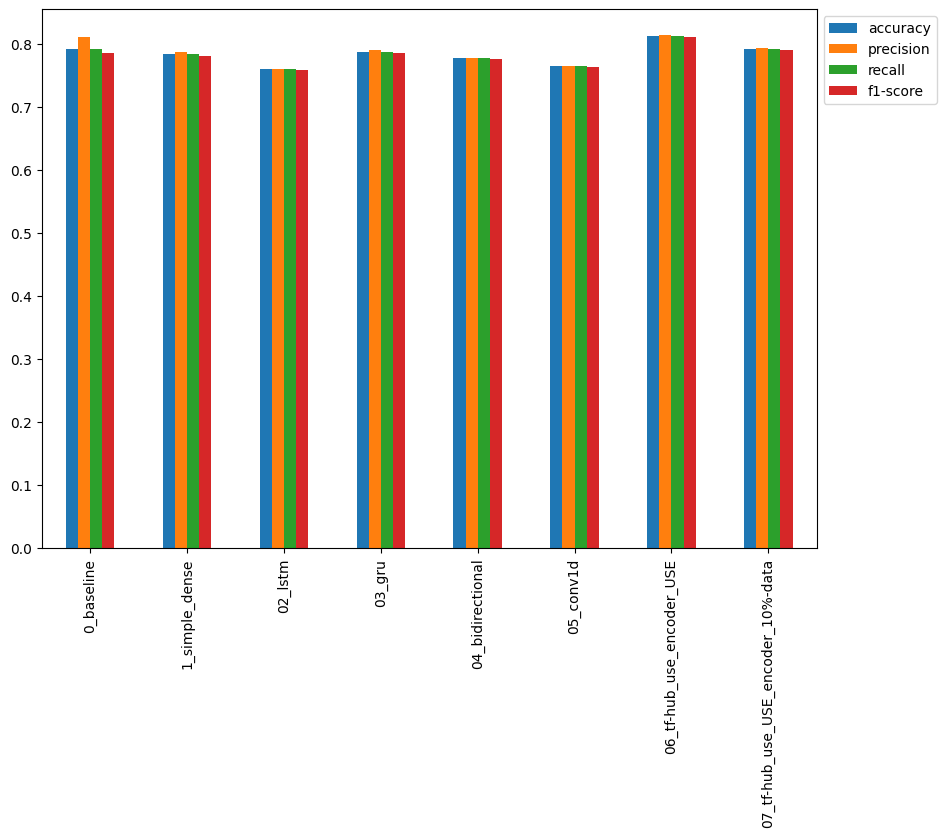

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

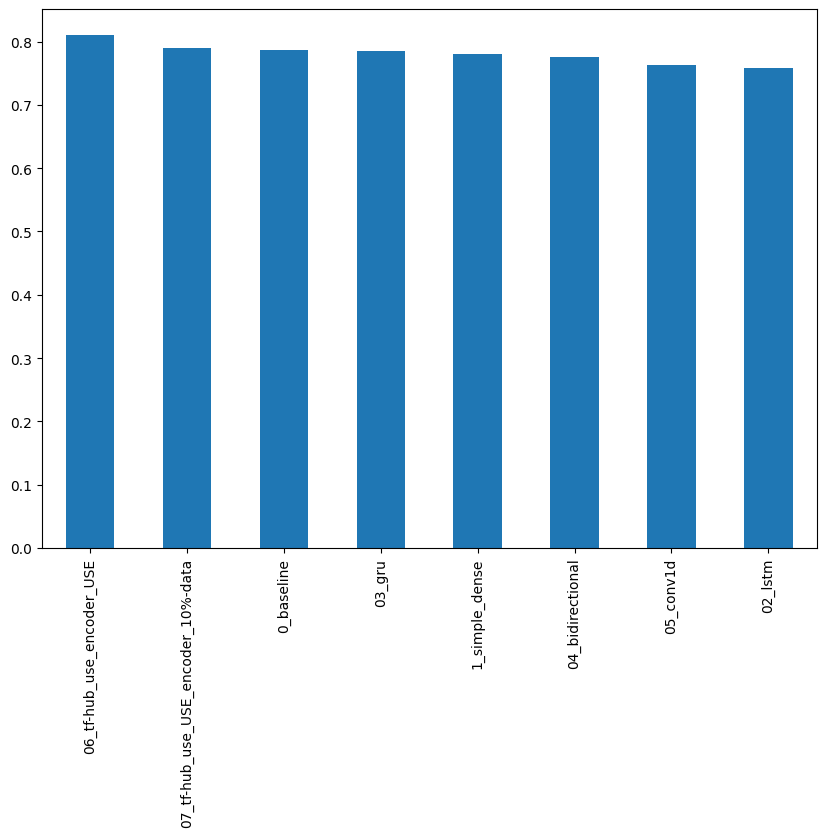

In [ ]:
# Sort them by their f1-scores
all_model_results.sort_values("f1-score", ascending=False)["f1-score"].plot(kind="bar", figsize=(10, 7));

In [ ]:
!tensorboard dev upload --logdir ./model_logs \
  --name "NLP modelling experiment" \
   --description "A series of different NLP modellings experiments with various models" \
   --one_shot # exits the uploader when upload has finished

2023-06-25 11:00:30.361639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


In [ ]:
!tensorboard dev list

2023-06-25 11:01:32.152486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   DVZX-CNWC

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_m

In [ ]:
!tensorboard dev delete --experiment_id kbQyWaKDS3G6HpejlpT2yA

2023-06-25 11:04:44.453211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will delete the 1 experiment(s) on
https://tensorboard.dev with the following experiment ID(s):

['kbQyWaKDS3G6HpejlpT2yA']

You have chosen to delete an experiment. All experiments uploaded
to TensorBoard.dev are publicly visible. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main.py", lin

In [ ]:
!tensorboard dev list

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/compat/__init__.py", line 42, in tf
    from tensorboard.compat import notf  # noqa: F401
ImportError: cannot import name 'notf' from 'tensorboard.compat' (/usr/local/lib/python3.10/dist-packages/tensorboard/compat/__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main.py", line 39, in run_main
    main_lib.global_init()
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main_lib.py", line 40, in global_init
    if getattr(tf, "__version__", "stub") == "stub":
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/lazy.py", line 65, in __getattr__
    return getattr(load_once(self), attr_name)
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/lazy.py", line 97, i

In [ ]:
model_6.save("model_6.h5")

In [ ]:
# Load the .h5 model
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})# We usedd TF-hub for model_6

In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 20ms/step - loss: 0.4304 - accuracy: 0.8123


[0.43036696314811707, 0.8123359680175781]

In [ ]:
# Save TF hub Sentence Encoder model to SaveModel
model_6.save("model_6_SavedModel_format")

In [ ]:
# Create DataFrame with validation sentences and best performing model predictions
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-06-25 11:07:49--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 74.125.196.128, 142.250.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  44.1MB/s    in 16s     

2023-06-25 11:08:05 (58.2 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.ind

In [ ]:
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 19ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [ ]:
model_8_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_8_pretrained_preds = tf.squeeze(tf.round(model_8_pretrained_pred_probs))
model_8_pretrained_preds[:10]

24/24 [==============================] - 1s 11ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create dataframe sentences, validation labels and best performing model
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_8_pretrained_preds,
                       "pred_probs": tf.squeeze(model_8_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
most_wrong = val_df[val_df["target"] != val_df["pred"]]
most_wrong = most_wrong.sort_values("pred_probs", ascending=False)
most_wrong[:10] # False positives

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835455
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [ ]:
# Check the false positives
for row in most_wrong[:10].itertuples(): # Into a tuple (1,2,3,4,5)
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

---

Target: 0, Pred: 1.0, Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

---

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

---

Target: 0, Pred: 1.0, Prob: 0.835454523563385
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

---

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

---

Target: 0, Pred: 1.0, Prob: 0.8148159384727478
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

Targ

In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [ ]:
# Making predictions on the test dataset nad visualizing the
test_sentences = test_df["text"].to_list() # Truning to list --> Cuased by pandas
test_sample=random.sample(test_sentences, 10)
for test_sample in test_sentences:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text: {test_sample}")
  print("---\n")

Streaming output truncated to the last 5000 lines.

http://t.co/92F4nKxjIu
---

1/1 [==============================] - 0s 56ms/step
Pred: 0, Prob: 0.4467196464538574
Text: @pnuts_mama Be strong. It's at times like this that arson happens. Push thru past the felony stage.
---

1/1 [==============================] - 0s 48ms/step
Pred: 1, Prob: 0.9636781811714172
Text: #BreakingNews Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters f... http://t.co/KTKDrGVHgX #rome
---

1/1 [==============================] - 0s 46ms/step
Pred: 1, Prob: 0.9345406293869019
Text: Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/WbCtkGGTY9
---

1/1 [==============================] - 0s 50ms/step
Pred: 0, Prob: 0.08629295974969864
Text: RT @an_opus: Elliott will be on probation for two years and will have to pay fines up to $1179.  http://t.co/72bcyfbTj3
---

1/1 [==========================

Exception ignored in: <function UniquePtr.__del__ at 0x7fe7d47b1990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 


Streaming output truncated to the last 5000 lines.
Text: Some guys explode ??
---

1/1 [==============================] - 0s 54ms/step
Pred: 0, Prob: 0.09839753061532974
Text: @magicallester I will die. I'm actually being serious. My heart will beat so fast it will fly out off my chest &amp; explode
---

1/1 [==============================] - 0s 54ms/step
Pred: 0, Prob: 0.1130242645740509
Text: Facebook Influence 2.0: Simple strategy to explode your Facebook page and create moreÛ_ http://t.co/rWPRtMIbHl
---

1/1 [==============================] - 0s 71ms/step
Pred: 0, Prob: 0.09890877455472946
Text: im sooooooo full my stomach is going to explode
---

1/1 [==============================] - 0s 68ms/step
Pred: 0, Prob: 0.09122642129659653
Text: I need a follow before I explode @GraysonDolan
---

1/1 [==============================] - 0s 68ms/step
Pred: 0, Prob: 0.027420537546277046
Text: I feel like I'm going to explode with excitement! Wonder begins within the hourÛ_Û_ https://t.co/z

KeyboardInterrupt: ignored

In [ ]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8145687227271431,
 'recall': 0.8123359580052494,
 'f1-score': 0.81078947666798}

In [ ]:
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred


In [ ]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model = model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 1s 21ms/step


(0.6781562730002406, 0.0008899688622050402)

In [ ]:
# Calckulate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                              samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.07380137700010891, 9.685220078754451e-05)

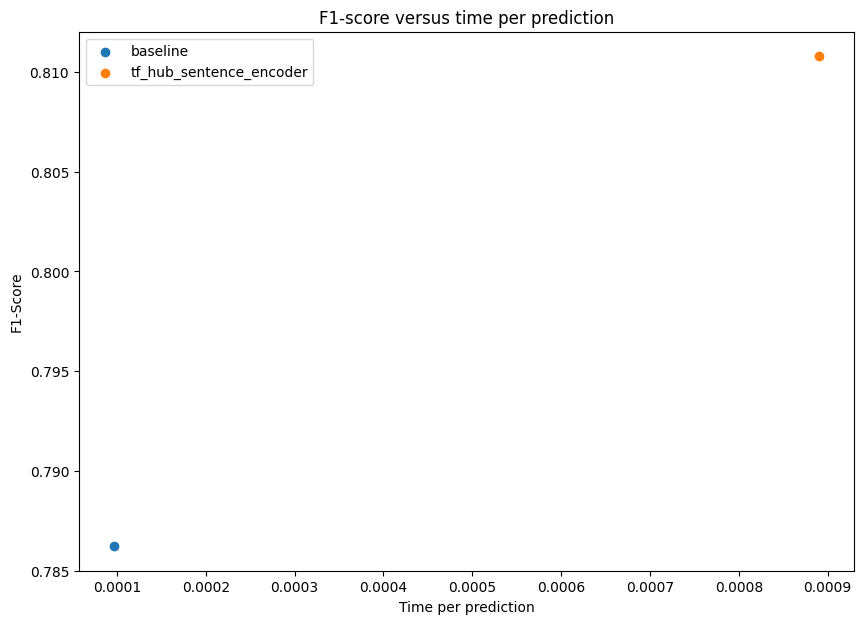

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1-score"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1-score"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");